# Comparaison gains PINNs/PINNs+Corr et FEM/PINNs+Corr

In [1]:
# sélection du cas test
testcase = 4
version = 7
assert testcase == 4 and version == 7
degree = 1
n_params = 50

**Idée :** On se place ici dans un des cas tests proposés : TestCase1,1_v2,2.

On cherche à vérifier les gains obtenues pour

- PINNs vs PINNs + Correction par addition
- FEM vs PINNs + Correction par addition

On choisira d'effectuer ces comparaisons sur 2 tailles de grilles fixées (20x20 et 40x40) en sélectionnant 50 paramètres aléatoires.

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import seaborn as sns
import dataframe_image as dfi

from modules.fenics_expressions import UexExpr
from scimba.equations.domain import SpaceTensor
from modules.solver_fem_4_donut_good import FEMSolver
from modules.utils import create_tree

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Using device: cpu


/home/flecourtier/anaconda3/envs/phifem_scimba_2/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400441250/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
from modules.testcases.d2.test_4.test_4_v7 import Run_laplacian2D,Poisson_2D
from modules.problem import TestCase4
problem = TestCase4(v=version)

dim_params = problem.nb_parameters
result_dir = "../../../results/2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/facteurs/"
create_tree(result_dir)
tab_nb_vert = [20,40]
tab_h = []
for nb_vert in tab_nb_vert:
    solver = FEMSolver(nb_cell=nb_vert-1, params=[[]], problem=problem, degree=degree)
    tab_h.append(np.round(solver.mesh.hmax(),2))

hmax =  0.13314799984383346
hmax =  0.06893171898161234


2
[[-0.5, 0.500001], [-0.5, 0.500001]]
[[-0.5, 0.500001], [-0.5, 0.500001]]
>> load network /home/flecourtier/Bureau/Article1/code/networks/test_fe4_v7.pth
jsbdbshd
network loaded
Error  tensor([0.0006])


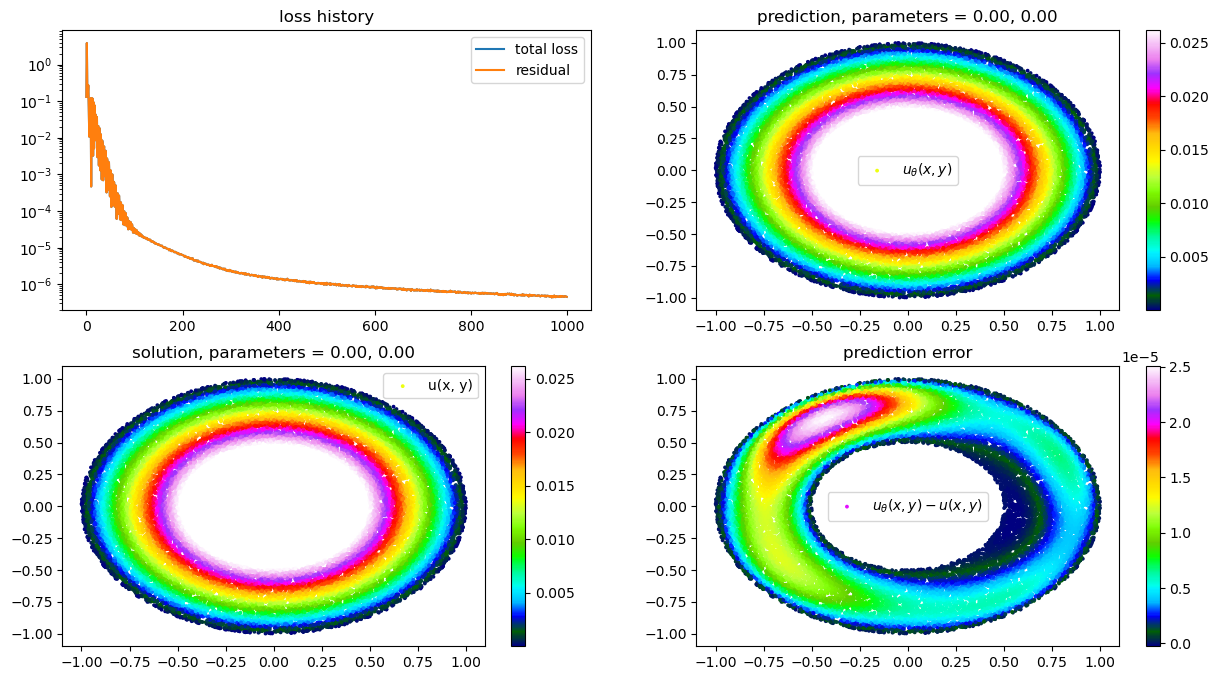

In [5]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [6]:
def get_params(n):
    parameter_domain = trainer.pde.parameter_domain.cpu().numpy()
    # pick n random parameters for each dimension
    params = []
    for i in range(dim_params):
        parami = np.random.uniform(parameter_domain[i][0], parameter_domain[i][1], n)
        params.append(parami)
    params = np.array(params).T
    return params

np.random.seed(0)
params = get_params(n_params)
params_str = np.array([f"{params[i][0].round(2)},{params[i][1].round(2)}" for i in range(n_params)])

## Erreurs FEM

In [8]:
def read_csv_FEM(testcase,degree):
    df_FEM = pd.read_csv(result_dir+f'FEM_case{testcase}_degree{degree}.csv')
    tab_err_FEM = df_FEM.values[2:,1:]
    return tab_err_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_degree{degree}.csv'
    col_names = [("FEM",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
        
    if not new_run and os.path.exists(csv_file):
        tab_err_FEM = read_csv_FEM(testcase,degree)
        df_FEM = pd.DataFrame(tab_err_FEM,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_FEM = np.zeros((n_params,len(tab_nb_vert)))
        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                _,norme_L2 = solver.fem(i)
                tab_err_FEM[i,j] = norme_L2
            print()
        
        df_FEM = pd.DataFrame(tab_err_FEM,columns=mi)
        df_FEM.to_csv(csv_file)
           
    return df_FEM, tab_err_FEM

In [9]:
df_FEM, tab_err_FEM = run_FEM(degree)

nb_vert=20
hmax =  0.13314799984383346
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
nb_vert=40
hmax =  0.06893171898161234
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 


In [31]:
df_FEM

method       FEM          
n_vert        20        40
h           0.13      0.07
0       0.004078  0.001046
1       0.004316  0.001083
2       0.004561  0.001221
3       0.004526  0.001151
4       0.004272  0.001092
5       0.004529  0.001140
6       0.004064  0.001059
7       0.004870  0.001202
8       0.004867  0.001207
9       0.004217  0.001081
10      0.004785  0.001191
11      0.004496  0.001144
12      0.004123  0.001065
13      0.005132  0.001267
14      0.004561  0.001192
15      0.004360  0.001143
16      0.004713  0.001270
17      0.004985  0.001240
18      0.004553  0.001188
19      0.005072  0.001258
20      0.005153  0.001361
21      0.004463  0.001116
22      0.004491  0.001206
23      0.004406  0.001116
24      0.004415  0.001179
25      0.004763  0.001206
26      0.004345  0.001132
27      0.005214  0.001286
28      0.004199  0.001065
29      0.004426  0.001135
30      0.004179  0.001082
31      0.004441  0.001108
32      0.004548  0.001166
33      0.004146  0.001075
34      0.004469  0.001188
35      0.004332  0.001090
36      0.004139  0.001052
37      0.004617  0.001168
38      0.004784  0.001199
39      0.004534  0.001202
40      0.004132  0.001062
41      0.004073  0.001063
42      0.004660  0.001169
43      0.004495  0.001202
44      0.004369  0.001095
45      0.004527  0.001136
46      0.004159  0.001095
47      0.004792  0.001252
48      0.004292  0.001144
49      0.004667  0.001207

## Erreurs PINNs

In [13]:
def get_test_sample(i,V_test,trainer):
    # get coordinates of the dof
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return X_test,mu_test

def FEniCSpred(i,V_test,trainer):
    X_test,mu_test = get_test_sample(i,V_test,trainer)
    pred = u_theta.setup_w_dict(X_test, mu_test)
    phi_tild = pred["w"][:,0].cpu().detach().numpy()
    
    u_PINNs = df.Function(V_test)
    u_PINNs.vector()[:] = phi_tild.copy()

    return u_PINNs

In [14]:
def read_csv_PINNs(testcase,degree):
    df_PINNs = pd.read_csv(result_dir+f'PINNs_case{testcase}_degree{degree}.csv')
    tab_err_PINNs = df_PINNs.values[2:,1:]
    
    return tab_err_PINNs

def run_PINNs(degree,new_run=False):
    csv_file = result_dir+f'PINNs_case{testcase}_degree{degree}.csv'
    col_names = [("PINNs",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
    if not new_run and os.path.exists(csv_file):
        tab_err_PINNs = read_csv_PINNs(testcase,degree)
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_PINNs = np.zeros((n_params,len(tab_nb_vert)))

        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            degree_PINNs = solver.high_degree
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                V_test = df.FunctionSpace(solver.mesh, 'CG', degree_PINNs)
                u_PINNs = FEniCSpred(i,V_test,trainer)
                                
                param = params[i]
                u_ex = UexExpr(param, degree=degree_PINNs, domain=solver.mesh, pb_considered=problem)

                uex_Vex = df.interpolate(u_ex,solver.V_ex)
                norme_L2 = (df.assemble((((uex_Vex - u_PINNs)) ** 2) * solver.dx) ** (0.5)) / (df.assemble((((uex_Vex)) ** 2) * solver.dx) ** (0.5))
            
                tab_err_PINNs[i,j] = norme_L2
            print()

        
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        df_PINNs.to_csv(csv_file)
        
    return df_PINNs, tab_err_PINNs

In [15]:
df_PINNs, tab_err_PINNs = run_PINNs(degree)

nb_vert=20
hmax =  0.13314799984383346
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
nb_vert=40
hmax =  0.06893171898161234
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 


## Erreurs Corr

In [20]:
def read_csv_Corr(testcase,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_degree{degree}.csv')
    tab_err_Corr = df_Corr.values[2:,1:]
    
    return tab_err_Corr

def run_Corr(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_degree{degree}.csv'
    col_names = [("Corr",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
    if not new_run and os.path.exists(csv_file):
        tab_err_Corr = read_csv_Corr(testcase,degree)
        df_Corr = pd.DataFrame(tab_err_Corr,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_Corr = np.zeros((n_params,len(tab_nb_vert)))

        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            degree_Corr = solver.high_degree
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                V_test = df.FunctionSpace(solver.mesh, 'CG', degree_Corr)
                u_PINNs = FEniCSpred(i,V_test,trainer)
                u_PINNs_inter = FEniCSpred(i,solver.V,trainer)
                
                _,_,norme_L2 = solver.corr_add(i,u_PINNs,u_PINNs_inter)
                tab_err_Corr[i,j] = norme_L2
            print()

        df_Corr = pd.DataFrame(tab_err_Corr,columns=mi)
        df_Corr.to_csv(csv_file)
        
    return df_Corr, tab_err_Corr

In [21]:
df_Corr, tab_err_Corr = run_Corr(degree)

nb_vert=20
hmax =  0.13314799984383346
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
nb_vert=40
hmax =  0.06893171898161234
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 


## Dataframe erreurs

In [22]:
# concatenate dataframe : for each columns, we have the error for each method
# we want a multiindex dataframe with FEM, PINNs and Corr for each n_vert and h
col_names = [("FEM",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))] + \
        [("PINNs",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))] + \
        [("Corr",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))]

mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
row_names = [str(i) + " : " + params_str[i] for i in range(n_params)]
df = pd.DataFrame(columns=mi,index=row_names)

for i in range(n_params):
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j]] = tab_err_FEM[i,j]
        j2=j+1
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j2+j]] = tab_err_PINNs[i,j]
        j3 = j2+j+1
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j3+j]] = tab_err_Corr[i,j]
        
df.to_csv(result_dir+f'comparison_case{testcase}_degree{degree}.csv')

## Dataframe facteurs

In [23]:
facteurs_PINNs_Corr = df["PINNs"] / df["Corr"]
facteurs_FEM_PINNs = df["FEM"] / df["PINNs"]
facteurs_FEM_Corr = df["FEM"] / df["Corr"]

col_names = [("FEM/PINNs",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))] + \
        [("PINNs/Corr",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))] + \
        [("FEM/Corr",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))]
mi = pd.MultiIndex.from_tuples(col_names, names=["facteurs","n_vert","h"])

index_names = [str(i) + " : " + params_str[i] for i in range(n_params)]
df_facteurs = pd.DataFrame(columns=mi,index=index_names)

for i in range(n_params):
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j]] = facteurs_FEM_PINNs.to_numpy()[i,j]
        j2=j+1
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j2+j]] = facteurs_PINNs_Corr.to_numpy()[i,j]
        j3 = j2+j+1
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j3+j]] = facteurs_FEM_Corr.to_numpy()[i,j]
        
df_facteurs.to_csv(result_dir+f'comparison_facteurs_case{testcase}_degree{degree}.csv')


## Boxplots

In [24]:
sns.set_style('darkgrid')
sns.set_theme(style="ticks")
sns.set_context("paper")
    
def plot_boxplot(i):
    n_vert = tab_nb_vert[i]
    
    # on crée une dataframe contenant les facteurs pour chaque méthode avec n_vert=n_vert
    df_facteurs_n_vert = df_facteurs[[col for col in df_facteurs.columns if col[1] == str(n_vert)]]
    # on supprime la première colonne 
    df_facteurs_n_vert = df_facteurs_n_vert.drop(columns=[df_facteurs_n_vert.columns[0]])
    
    # on change les noms des colonnes
    df_facteurs_n_vert.columns = [col[0] for col in df_facteurs_n_vert.columns]

    sns.boxplot(data=df_facteurs_n_vert, orient="h", palette="Set2")
    plt.grid(axis="x", visible=True, which="both")
    plt.title(f"n_vert={n_vert}, n_params={n_params}")
    
    return df_facteurs_n_vert

def plot_table(df_facteurs_n_vert,ax):
    df_min = df_facteurs_n_vert.min(axis=0)
    df_max = df_facteurs_n_vert.max(axis=0)
    df_mean = df_facteurs_n_vert.mean(axis=0)
    
    df_val = pd.concat([df_min,df_max,df_mean],axis=1).T
    tab = df_val.values.T.astype(float)
    tab = np.round(tab,2)

    thetable = ax.table(cellText=tab, rowLabels=df_facteurs_n_vert.columns, colLabels=["min","max","mean"], loc='right', cellLoc='center', colLoc='center', bbox=[0,0,1,1])
    thetable.scale(1.,0.8)
    thetable.auto_set_font_size(False)
    
    ax.axis('off')

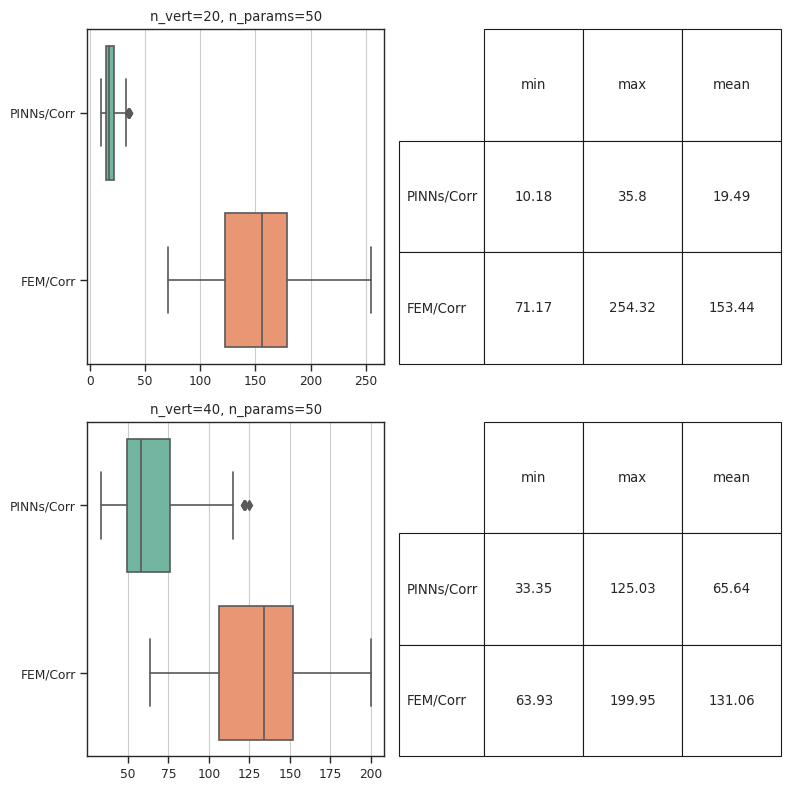

In [25]:
nb_test = len(tab_nb_vert)

plt.figure(figsize=(8,nb_test*4))

for i in range(nb_test):
    plt.subplot(nb_test,2,2*i+1)
    df_facteurs_n_vert = plot_boxplot(i)

    ax = plt.subplot(nb_test,2,2*i+2)
    plot_table(df_facteurs_n_vert,ax)

plt.tight_layout()
plt.savefig(result_dir+f'boxplot_facteurs_case{testcase}_degree{degree}.png')
plt.show()

## Table

In [26]:
def get_df_facteurs_n_vert(i):
    n_vert = tab_nb_vert[i]
    
    # on crée une dataframe contenant les facteurs pour chaque méthode avec n_vert=n_vert
    df_facteurs_n_vert = df_facteurs[[col for col in df_facteurs.columns if col[1] == str(n_vert)]]
    # on supprime la première colonne 
    df_facteurs_n_vert = df_facteurs_n_vert.drop(columns=[df_facteurs_n_vert.columns[0]])
    
    # on change les noms des colonnes
    df_facteurs_n_vert.columns = [col[0] for col in df_facteurs_n_vert.columns]
    
    return df_facteurs_n_vert

def get_values(df_facteurs_n_vert):
    df_min = df_facteurs_n_vert.min(axis=0)
    df_max = df_facteurs_n_vert.max(axis=0)
    df_mean = df_facteurs_n_vert.mean(axis=0)
    df_std = df_facteurs_n_vert.std(axis=0)
    
    return [df_min["PINNs/Corr"],df_max["PINNs/Corr"],df_mean["PINNs/Corr"],df_std["PINNs/Corr"]], \
            [df_min["FEM/Corr"],df_max["FEM/Corr"],df_mean["FEM/Corr"],df_std["FEM/Corr"]]

In [27]:
nb_test = len(tab_nb_vert)

tab_gains_on_PINNs = []
tab_gains_on_FEM = []

for i in range(nb_test):
    df_facteurs_n_vert = get_df_facteurs_n_vert(i)
    gains_on_PINNs,gains_on_FEM = get_values(df_facteurs_n_vert)
    tab_gains_on_PINNs.append(gains_on_PINNs)
    tab_gains_on_FEM.append(gains_on_FEM)
    
tab_gains_on_PINNs = np.array(tab_gains_on_PINNs)
tab_gains_on_FEM = np.array(tab_gains_on_FEM)

columns= ["N","min_PINNs","max_PINNs","mean_PINNs","std_PINNs","min_FEM","max_FEM","mean_FEM","std_FEM"]

df_gains = pd.DataFrame(np.concatenate([np.array(tab_nb_vert).reshape(-1,1),tab_gains_on_PINNs,tab_gains_on_FEM],axis=1),columns=columns)

In [28]:
df_gains

,N,min_PINNs,max_PINNs,mean_PINNs,std_PINNs,min_FEM,max_FEM,mean_FEM,std_FEM
0,20.0,10.180027,35.804754,19.485469,6.861372,71.168040,254.319734,153.435123,39.708336
1,40.0,33.347196,125.028381,65.638953,23.780848,63.933474,199.950474,131.063669,31.185782


In [29]:
result_file = result_dir+f'gains_table_case{testcase}_degree{degree}'

df_gains.to_csv(result_file+'.csv')

df_styled = df_gains.style.format("{:.2e}")
dfi.export(df_styled,result_file+".png",dpi=1000)